# Introduction

Movie recommendation systems are widely used in many online platforms like Netflix, Amazon Prime, and Hulu. These systems are designed to provide personalized movie recommendations to users based on their viewing history, ratings, and preferences.

In this notebook, we will be building a movie recommender system using collaborative filtering on the MovieLens dataset. The first dataset contains 100,000 ratings from 1000 users for 1700 movies. The second dataset contains 25 million ratings from 270,000 users for over 62,000 movies. Our goal is to build a system that can predict how a user will rate a movie that they have not seen yet, and recommend the movies with the highest predicted ratings.

We will be using maximum likelihood estimation (MLE) to build our recommendation system. MLE is a commonly used statistical method that estimates the parameters of a statistical model by maximizing the likelihood of the observed data. In our case, the model will be trained on the MovieLens dataset and the parameters will be the user preferences and the movie features.

We will work in an iterative manner, starting with a simple model and then adding more complexity as we go along. The first model would consist of basic bias terms for users and movies, and user-movie interactions. We will then add genre as a feature to the model, and finally we explore the use of cosine similarity and correlation to improve the performance of the model.

This notebook will follow the approach of an EDA and then some data processing as we go along. Followed by the model building and evaluation. This particular notebook, `100k_dataset_ipynb`, will serve as the initial set of experiments and investigation. We transfer the learnings of this notebook to the final notebook, `25m_dataset.ipynb`, where these experiments are then carried on the larger dataset to investigate the feasibility of taking this to production. This notebook walks through all the steps taken to make training possible and scalable. 

This notebook is intended for technical people. If you wish to have a view of methods used, mathematical derivations and experiments, this notebook is here for you perusal. If you are a business executive, please review the `Movie_Recommender_System_POC.pdf` document. This document is intended for a business audience that is interested in the business case, and value such a system can bring to their business. 


Let's get started!

The notebook is structured in the following way:

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Data Processing](#2.-Data-Processing)
3. [Model Building: Biases](#3.-Model-Building:-Biases)
4. [Hyperparameter Tuning: Grid Search](#4.-Hyperparameter-Tuning:-Grid-Search)
5. [Model Evaluation: Biases](#5.-Model-Evaluation:-Biases)
6. [Model Building: Biases and Genre's](#6.-Model-Building:-Biases-and-Genre's)
7. [Model Evaluation: Biases and Genre's](#Bias-Genre-Model-Evaluation)
8. [Model Building: Biases, Genre's and Cosine Similarity](#Bias-Genre-Cosine-Model-Building)
9. [Model Evaluation: Biases, Genre's and Cosine Similarity](#Bias-Genre-Cosine-Model-Evaluation)
10. [Results and Conclusion](#Results)




# 1. Exploratory Data Analysis

<a id='EDA'></a>

In [466]:
# import some basic EDA libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw
%matplotlib inline

In [467]:
# some ml imports
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.preprocessing import StandardScaler # for scaling
from sklearn.metrics import mean_squared_error, r2_score # for regression
from sklearn.preprocessing import MultiLabelBinarizer # for one hot encoding
import itertools # for creating grid search combinations

In [468]:
# set the file path to read in the data
# filepath = '../data/ml-25m/'
filepath = '../data/ml-latest-small/' # for debugging

In [469]:
movies = pd.read_csv(filepath + 'movies.csv')
ratings = pd.read_csv(filepath + 'ratings.csv')
tags = pd.read_csv(filepath + 'tags.csv')

In [470]:
# check the data
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [471]:
# get some basic info about the data
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [472]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [473]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [474]:
# out of curiousity let's covert the timestamp to a datetime object
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [475]:
# what is the datetime of the oldest and latest movie rating?
print(f"Ratings are collected from {str(ratings['datetime'].min())[0:4]} to {str(ratings['datetime'].max())[0:4]}")

Ratings are collected from 1996 to 2018


In [476]:
# count the number of unique users and movies
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


In [477]:
# check how many movies are in the ratings dataframe but not in the movies dataframe
movies_not_in_ratings = movies[~movies['movieId'].isin(ratings['movieId'])]
print('Number of movies in movies but not in ratings: ' + str(movies_not_in_ratings.shape[0]))
print('So there are ' + str(movies_not_in_ratings.shape[0]) + ' movies that have not been rated by any user.')

Number of movies in movies but not in ratings: 18
So there are 18 movies that have not been rated by any user.


In [478]:
# discard movies that have not been rated by any user
movies = movies[movies['movieId'].isin(ratings['movieId'])]

Calculating best minimal value for power law fit


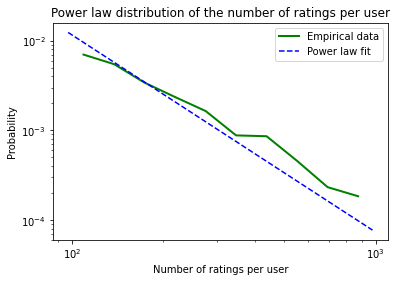

In [479]:
# plot the power law distribution of the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
fit = powerlaw.Fit(ratings_per_user)
fit.plot_pdf(color='g', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=plt.gca())
plt.xlabel('Number of ratings per user')
plt.ylabel('Probability')
plt.title('Power law distribution of the number of ratings per user')
plt.legend(['Empirical data', 'Power law fit'])
plt.show()

In [480]:
# check if there are movies rated 1.5, 2.5, 3.5, 4.5
_check_ratings_increments = ratings['rating'].unique()
print(f'The rating increments are: {sorted(_check_ratings_increments)}')

The rating increments are: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


### Power laws (/Zipf's law) in the data

Based on the power law plot of the rating distribution that we generated earlier, it appears that there is evidence of a power law in the data. A power law is characterized by a straight line on a log-log plot, and the plot we generated does show a linear relationship between the log of the rating values and the log of their corresponding frequency counts.

However, it's important to note that the presence of a power law in a dataset is not always conclusive evidence of a specific underlying mechanism or process. Power laws are often observed in many different types of natural and social phenomena, and it's possible for a dataset to exhibit a power law distribution even if the underlying mechanism is not truly a power law. In addition, the presence of noise or other confounding factors can also affect the accuracy and interpretation of the power law.

To confirm whether the data follows a power law distribution, we perform a goodness-of-fit test, to compare the distribution of the data to a power law distribution.

In [481]:
# perform goodness of fit test
fit.distribution_compare('power_law', 'lognormal')

(-14.523547260028481, 0.0005234768989664919)

The output of `fit.distribution_compare('power_law', 'lognormal')` is a tuple with two values: the log-likelihood ratio statistic and the p-value of the test.

In this case, the log-likelihood ratio statistic is -14.5 and the p-value is 0.0005.

The log-likelihood ratio statistic is a measure of the relative goodness of fit of the two distributions being compared (in this case, a power law distribution and a log-normal distribution). A negative value of the statistic indicates that the power law distribution fits the data better than the log-normal distribution.

The p-value is a measure of the strength of evidence against the null hypothesis, which is that the power law distribution and the log-normal distribution fit the data equally well. A p-value less than 0.05 (or some other pre-specified significance level) indicates that there is strong evidence against the null hypothesis and that the power law distribution fits the data significantly better than the log-normal distribution. (The null hypothesis is that the log-normal distribution is a better fit to the data).

In summary, the output (-14.5, 0.0005) suggests that the power law distribution is a significantly better fit to the data than the log-normal distribution, based on the log-likelihood ratio test at a significance level of 0.05.

### Scale free behavior in the data

The presence of the power law in the rating distribution would suggest that the distribution of ratings across movies follows a scale-free pattern. In other words, a few movies would receive a large number of ratings, while the majority of movies would receive relatively few ratings.

Similarly, if a power law distribution is observed in the user activity data, it would suggest that the distribution of user ratings follows a scale-free pattern. This means that a few users would rate a large number of movies, while the majority of users would rate relatively few movies.

The observation of a power law distribution in the ratings data or user activity data could have implications for the design of recommender systems based on this dataset. Specifically, it suggests that a few movies and users have a disproportionately large influence on the overall ratings distribution, and therefore their ratings should be given greater or smaller weight in any recommendation algorithm depending on what we are trying to achieve.

For now, let us continue with our analysis of the data.

<AxesSubplot:xlabel='rating', ylabel='count'>

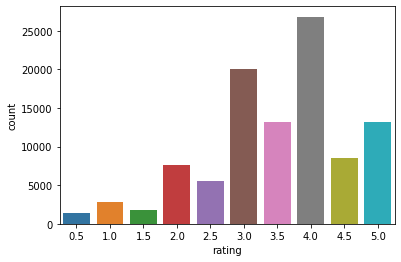

In [482]:
# let's see the distribution of ratings
sns.countplot(x='rating', data=ratings)

In [483]:
# count the number of ratings
ratings['rating'].value_counts().sort_index()

0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: rating, dtype: int64

We see that movies tend to be rated more frequently from 3 to 5, while ratings of 1 and 2 are less frequent. This is consistent with the power law plot that we generated earlier.

In [484]:
# let's see how many ratings each user has given
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user.head()

userId
1    232
2     29
3     39
4    216
5     44
Name: rating, dtype: int64

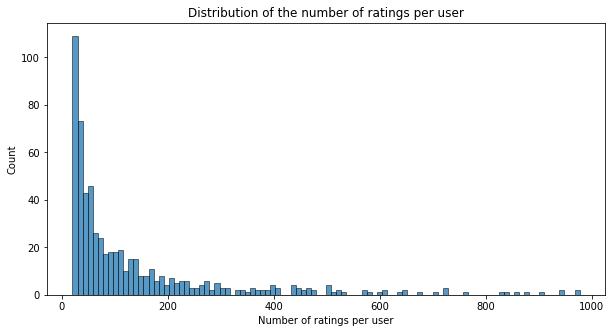

In [485]:
# plot the distribution of the number of ratings per user
# create a dataframe with the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_user, kde=False, bins=100)
plt.xlabel('Number of ratings per user')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per user')
plt.show()

In [486]:
# let's see how many ratings each movie has received
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie.head()

movieId
1    215
2    110
3     52
4      7
5     49
Name: rating, dtype: int64

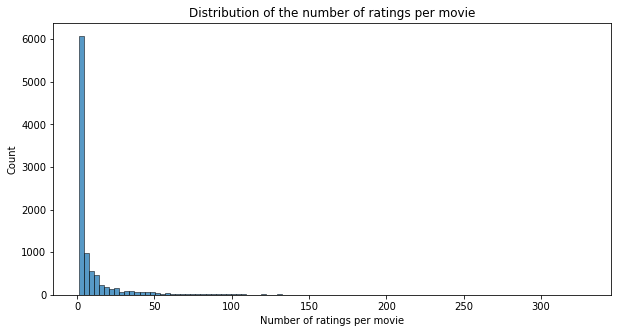

In [487]:
# plot the distribution of the number of ratings per movie
# create a dataframe with the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie = ratings_per_movie[ratings_per_movie < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_movie, kde=False, bins=100)
plt.xlabel('Number of ratings per movie')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per movie')
plt.show()

<AxesSubplot:ylabel='None'>

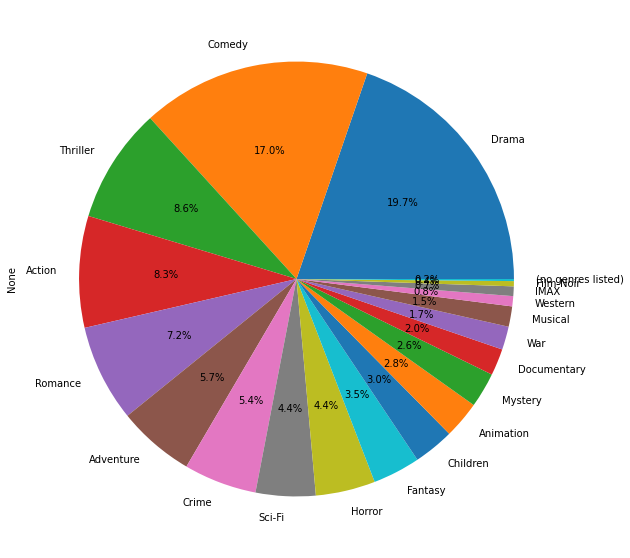

In [488]:
# plot a pie chart of the genres (even though pie charts are not the best way convey information)
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

<AxesSubplot:title={'center':'Number of movies in each genre'}, xlabel='Genre', ylabel='Number of movies'>

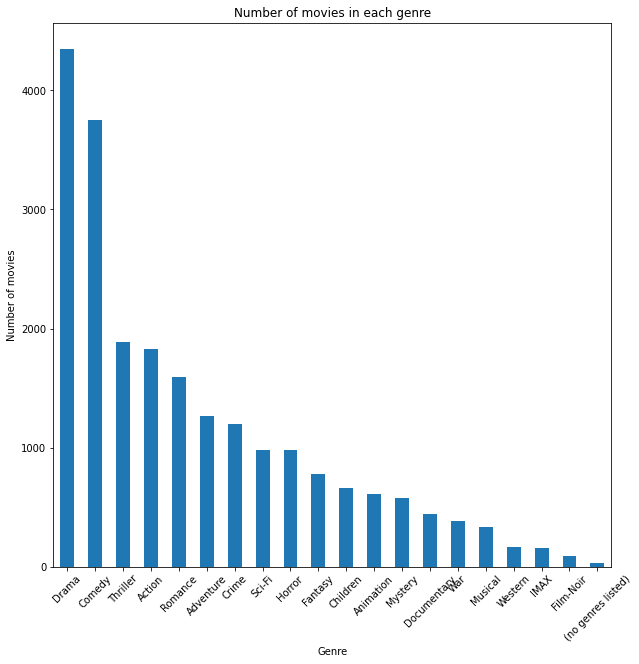

In [489]:
# plot the bar chart of the number of movies in each genre 
# bar charts are much better than pie charts. Propotionally, they are much easier to interpret
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='bar', figsize=(10,10), rot=45, title='Number of movies in each genre', xlabel='Genre', ylabel='Number of movies')


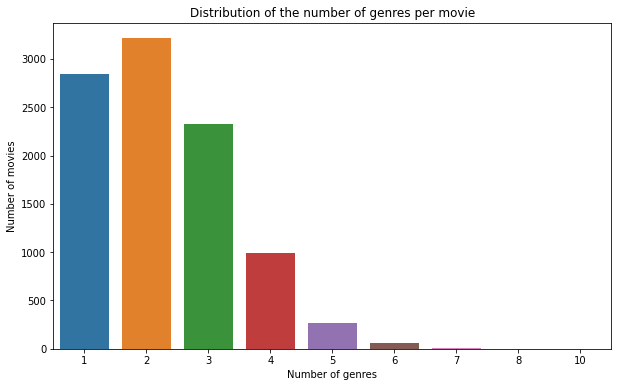

In [490]:
# plot the distribution of the number of genres per movie
movies['num_genres'] = movies['genres'].str.split('|').apply(len)
movies['num_genres'].value_counts()

# plot the distribution of the number of genres per movie
plt.figure(figsize=(10, 6))
sns.countplot(x='num_genres', data=movies)
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.title('Distribution of the number of genres per movie')
plt.show()

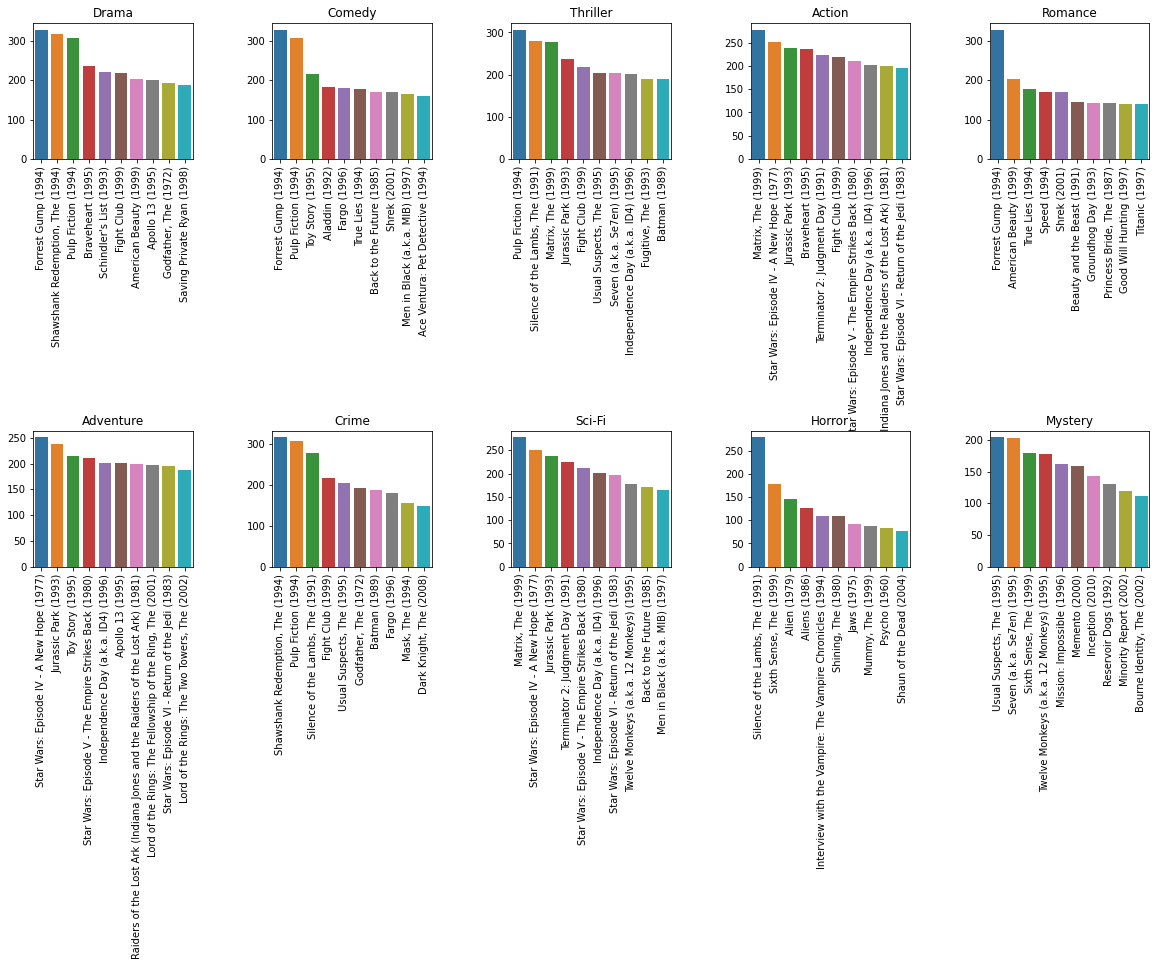

In [491]:
# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
top_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime', 'Sci-Fi', 'Horror', 'Mystery']
top_movies = movies[movies['genres'].str.contains('|'.join(top_genres))]
top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
top_movies = top_movies.sort_values('rating', ascending=False).head(10)
top_movies

# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
# create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
# plot the top 10 movies in terms of number of ratings received for each genre in each subplot
for i, genre in enumerate(top_genres):
    top_movies = movies[movies['genres'].str.contains(genre)]
    top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
    top_movies = top_movies.sort_values('rating', ascending=False).head(10)
    sns.barplot(x='title', y='rating', data=top_movies, ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(genre)
    axes[i//5, i%5].set_xlabel('')
    axes[i//5, i%5].set_ylabel('')
    axes[i//5, i%5].tick_params(axis='x', labelrotation=90)
# adjust the subplot layout to favor space between subplots
plt.subplots_adjust(wspace=0.5, hspace=2)
plt.show()

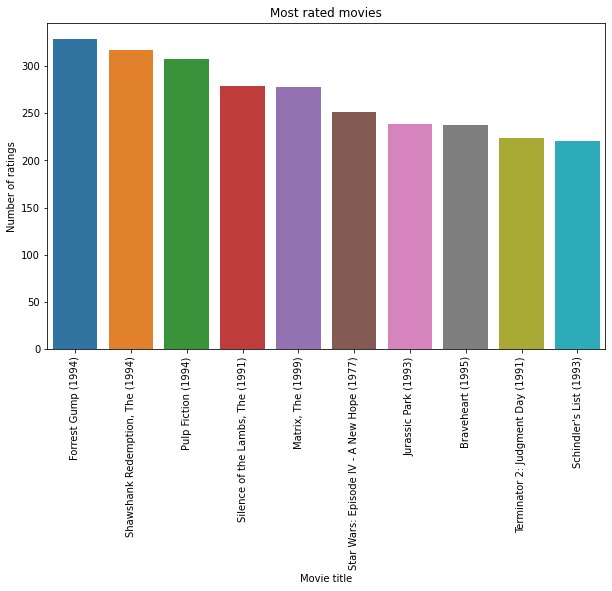

   movieId  rating                                      title  \
0      356     329                        Forrest Gump (1994)   
1      318     317           Shawshank Redemption, The (1994)   
2      296     307                        Pulp Fiction (1994)   
3      593     279           Silence of the Lambs, The (1991)   
4     2571     278                         Matrix, The (1999)   
5      260     251  Star Wars: Episode IV - A New Hope (1977)   
6      480     238                       Jurassic Park (1993)   
7      110     237                          Braveheart (1995)   
8      589     224          Terminator 2: Judgment Day (1991)   
9      527     220                    Schindler's List (1993)   

                             genres  num_genres  
0          Comedy|Drama|Romance|War           4  
1                       Crime|Drama           2  
2       Comedy|Crime|Drama|Thriller           4  
3             Crime|Horror|Thriller           3  
4            Action|Sci-Fi|Thrille

In [492]:
# plot the most rated movies
ratings_per_movie = ratings.groupby('movieId').count()['rating'].sort_values(ascending=False)
ratings_per_movie = ratings_per_movie.reset_index()
ratings_per_movie = ratings_per_movie.merge(movies, on='movieId', how='inner')
ratings_per_movie

# plot the most rated movies
plt.figure(figsize=(10, 6))
sns.barplot(x='title', y='rating', data=ratings_per_movie[0:10])
plt.xlabel('Movie title')
plt.ylabel('Number of ratings')
plt.title('Most rated movies')
plt.xticks(rotation=90)
plt.show()

print(ratings_per_movie[0:10])


# 2. Data Processing

In [493]:
# get the ratings per movie and per user
ratings_per_movie = ratings.groupby('movieId').count()['rating'].sort_values(ascending=False)
ratings_per_user = ratings.groupby('userId').count()['rating'].sort_values(ascending=False)

In [494]:
# clean the data
# remove movies with less than 20 ratings
min_movie_ratings = 20
filter_movies = ratings_per_movie > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

# remove users who have given less than 20 ratings
min_user_ratings = 20
filter_users = ratings_per_user > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

# filter data
ratings_new = ratings[(ratings['movieId'].isin(filter_movies)) & (ratings['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

The original data frame shape:	(100836, 5)
The new data frame shape:	(66405, 5)


In [495]:
ratings_new

,userId,movieId,rating,timestamp,datetime
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...,...
100803,610,148626,4.0,1493847175,2017-05-03 21:32:55
100808,610,152081,4.0,1493846503,2017-05-03 21:21:43
100829,610,164179,5.0,1493845631,2017-05-03 21:07:11
100830,610,166528,4.0,1493879365,2017-05-04 06:29:25


In [496]:
# count the number of unique movies and users
n_movies = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()
print('Number of unique movies: {}'.format(n_movies))
print('Number of unique users: {}'.format(n_users))

Number of unique movies: 1235
Number of unique users: 596


In [497]:
movies_new = movies[movies['movieId'].isin(ratings_new['movieId'].unique())]

In [498]:
movies_new

,movieId,title,genres,num_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,2,Jumanji (1995),Adventure|Children|Fantasy,3
2,3,Grumpier Old Men (1995),Comedy|Romance,2
4,5,Father of the Bride Part II (1995),Comedy,1
5,6,Heat (1995),Action|Crime|Thriller,3
...,...,...,...,...
9162,148626,"Big Short, The (2015)",Drama,1
9223,152081,Zootopia (2016),Action|Adventure|Animation|Children|Comedy,5
9392,164179,Arrival (2016),Sci-Fi,1
9433,166528,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,4


In [499]:
# see which movieIds in ratings_new have the highest number of views
ratings_per_movie = ratings_new.groupby('movieId').count()['rating']
ratings_per_movie = ratings_per_movie.sort_values(ascending=False)
ratings_per_movie

movieId
356     327
318     315
296     306
593     278
2571    277
       ... 
1231     20
2137     20
2125     20
203      20
372      20
Name: rating, Length: 1235, dtype: int64

In [500]:
# The most popular movies
top_movies = movies[movies['movieId'].isin(ratings_per_movie.sort_values(ascending=False).head(10).index)]
# create a column with the number of ratings, num_ratings for each movie
top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner').rename(columns={'rating': 'num_ratings'})
top_movies

,movieId,title,genres,num_genres,num_ratings
0,110,Braveheart (1995),Action|Drama|War,3,237
1,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,3,251
2,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4,306
3,318,"Shawshank Redemption, The (1994)",Crime|Drama,2,315
4,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4,327
5,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,4,237
6,527,Schindler's List (1993),Drama|War,2,218
7,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,2,224
8,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,3,278
9,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,3,277


In [501]:
# see which user has the highest number of ratings
ratings_per_user.sort_values(ascending=False)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
147      20
207      20
189      20
595      20
53       20
Name: rating, Length: 610, dtype: int64

In [502]:
# merge ratings_new and movies_new on movieId
df = ratings_new.merge(movies_new, on='movieId', how='inner')

In [503]:
df

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres
0,1,1,4.0,964982703,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,5,1,4.0,847434962,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
2,7,1,4.5,1106635946,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
3,15,1,2.5,1510577970,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
4,17,1,4.5,1305696483,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
...,...,...,...,...,...,...,...,...
66400,572,2013,1.0,945887535,1999-12-22 18:32:15,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3
66401,577,2013,3.0,945967440,1999-12-23 16:44:00,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3
66402,590,2013,2.5,1258420216,2009-11-17 01:10:16,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3
66403,597,2013,3.0,941640433,1999-11-03 14:47:13,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3


In [504]:
# create a mapping that resets the userId index to start from 0 and return the dictionary of the form {new_userId: old_userId} and update the dataframe
new_userId = {new: old for old, new in enumerate(ratings_new['userId'].unique())}
ratings_new['userId'] = ratings_new['userId'].map(new_userId)

# create a mapping that resets the movieId index to start from 0 and return the dictionary of the form {new_movieId: old_movieId} and update the dataframe
new_movieId = {new: old for old, new in enumerate(movies_new['movieId'].unique())}
movies_new['movieId'] = movies_new['movieId'].map(new_movieId)

# update ratings_new with the movie mappings
ratings_new['movieId'] = ratings_new['movieId'].map(new_movieId)

# update df with the mappings
df['userId'] = df['userId'].map(new_userId)
df['movieId'] = df['movieId'].map(new_movieId)


<ipython-input-504-afd5bc0158fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_new['userId'] = ratings_new['userId'].map(new_userId)
<ipython-input-504-afd5bc0158fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['movieId'] = movies_new['movieId'].map(new_movieId)
<ipython-input-504-afd5bc0158fb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [505]:
# show only userID=0

df[df['userId'] == 0]

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres
0,0,0,4.0,964982703,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
215,0,2,4.0,964981247,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,2
267,0,4,4.0,964982224,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,3
369,0,23,5.0,964983815,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,2
572,0,25,5.0,964982931,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,3
...,...,...,...,...,...,...,...,...
15365,0,749,5.0,964981909,2000-07-30 18:31:49,"Road Warrior, The (Mad Max 2) (1981)",Action|Adventure|Sci-Fi|Thriller,4
15404,0,752,4.0,964982417,2000-07-30 18:40:17,Big Trouble in Little China (1986),Action|Adventure|Comedy|Fantasy,4
15431,0,759,5.0,964981855,2000-07-30 18:30:55,X-Men (2000),Action|Adventure|Sci-Fi,3
15564,0,761,4.0,964981220,2000-07-30 18:20:20,What About Bob? (1991),Comedy,1


In [506]:
df

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres
0,0,0,4.0,964982703,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,4,0,4.0,847434962,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
2,6,0,4.5,1106635946,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
3,14,0,2.5,1510577970,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
4,16,0,4.5,1305696483,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
...,...,...,...,...,...,...,...,...
66400,559,486,1.0,945887535,1999-12-22 18:32:15,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3
66401,563,486,3.0,945967440,1999-12-23 16:44:00,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3
66402,576,486,2.5,1258420216,2009-11-17 01:10:16,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3
66403,582,486,3.0,941640433,1999-11-03 14:47:13,"Poseidon Adventure, The (1972)",Action|Adventure|Drama,3


In [507]:
# show movies with movieId=289

movies_new[movies_new['movieId'] == 289]

,movieId,title,genres,num_genres
880,289,Delicatessen (1991),Comedy|Drama|Romance,3


In [508]:
# Check the number of users in the dataset remains unchanged after the mapping
n_users - ratings_new['userId'].nunique()

0

In [509]:
# Check the number of movies in the dataset remains unchanged after the mapping
n_movies - ratings_new['movieId'].nunique()

0

In [510]:
# check that the mapping is correct
ratings_new

,userId,movieId,rating,timestamp,datetime
0,0,0,4.0,964982703,2000-07-30 18:45:03
1,0,2,4.0,964981247,2000-07-30 18:20:47
2,0,4,4.0,964982224,2000-07-30 18:37:04
3,0,23,5.0,964983815,2000-07-30 19:03:35
4,0,25,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...,...
100803,595,1230,4.0,1493847175,2017-05-03 21:32:55
100808,595,1231,4.0,1493846503,2017-05-03 21:21:43
100829,595,1232,5.0,1493845631,2017-05-03 21:07:11
100830,595,1233,4.0,1493879365,2017-05-04 06:29:25


In [511]:
movies_new

,movieId,title,genres,num_genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,1,Jumanji (1995),Adventure|Children|Fantasy,3
2,2,Grumpier Old Men (1995),Comedy|Romance,2
4,3,Father of the Bride Part II (1995),Comedy,1
5,4,Heat (1995),Action|Crime|Thriller,3
...,...,...,...,...
9162,1230,"Big Short, The (2015)",Drama,1
9223,1231,Zootopia (2016),Action|Adventure|Animation|Children|Comedy,5
9392,1232,Arrival (2016),Sci-Fi,1
9433,1233,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,4


In [512]:
# check the dictionary of the form {new_userId: old_userId}
new_userId

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 54: 52,
 55: 53,
 56: 54,
 57: 55,
 58: 56,
 59: 57,
 60: 58,
 61: 59,
 62: 60,
 63: 61,
 64: 62,
 65: 63,
 66: 64,
 67: 65,
 68: 66,
 69: 67,
 70: 68,
 71: 69,
 72: 70,
 73: 71,
 74: 72,
 75: 73,
 76: 74,
 77: 75,
 78: 76,
 79: 77,
 80: 78,
 81: 79,
 82: 80,
 83: 81,
 84: 82,
 85: 83,
 86: 84,
 87: 85,
 88: 86,
 89: 87,
 90: 88,
 91: 89,
 92: 90,
 93: 91,
 94: 92,
 95: 93,
 96: 94,
 97: 95,
 98: 96,
 99: 97,
 100: 98,
 101: 99,
 102: 100,
 103: 101,
 104: 102,
 105: 103,
 106: 104,
 107: 105,
 108: 106,
 109: 107,
 110: 108,
 111: 109,
 112: 1

In [513]:
#check that the length of the dictionary is equal to the number of unique users
len(new_userId) == n_users

True

In [514]:
# check the dictionary of the form {new_movieId: old_movieId}
new_movieId

{1: 0,
 2: 1,
 3: 2,
 5: 3,
 6: 4,
 7: 5,
 10: 6,
 11: 7,
 16: 8,
 17: 9,
 19: 10,
 21: 11,
 22: 12,
 24: 13,
 25: 14,
 29: 15,
 31: 16,
 32: 17,
 34: 18,
 36: 19,
 39: 20,
 44: 21,
 45: 22,
 47: 23,
 48: 24,
 50: 25,
 52: 26,
 58: 27,
 60: 28,
 62: 29,
 65: 30,
 70: 31,
 95: 32,
 101: 33,
 104: 34,
 105: 35,
 107: 36,
 110: 37,
 111: 38,
 112: 39,
 135: 40,
 141: 41,
 145: 42,
 150: 43,
 151: 44,
 153: 45,
 158: 46,
 160: 47,
 161: 48,
 163: 49,
 165: 50,
 168: 51,
 170: 52,
 172: 53,
 173: 54,
 180: 55,
 185: 56,
 186: 57,
 193: 58,
 196: 59,
 198: 60,
 203: 61,
 204: 62,
 207: 63,
 208: 64,
 215: 65,
 216: 66,
 223: 67,
 224: 68,
 225: 69,
 227: 70,
 230: 71,
 231: 72,
 235: 73,
 236: 74,
 237: 75,
 246: 76,
 247: 77,
 252: 78,
 253: 79,
 256: 80,
 260: 81,
 261: 82,
 262: 83,
 265: 84,
 266: 85,
 272: 86,
 273: 87,
 276: 88,
 277: 89,
 282: 90,
 288: 91,
 292: 92,
 293: 93,
 296: 94,
 300: 95,
 303: 96,
 307: 97,
 315: 98,
 316: 99,
 317: 100,
 318: 101,
 327: 102,
 329: 103,
 333:

In [515]:
# check that the length of the dictionary is equal to the number of unique movies
len(new_movieId) == n_movies

True

In [516]:
# from ratings_new, create a users list where each element is a tuple of the form (userId, movieId, rating)
# select only the columns userId, movieId, rating and make sure that the values are of type int, int, float
users = ratings_new[['userId', 'movieId', 'rating']].values.tolist()
# parse the first two elements of each row as integers and the third as a float
users = [(int(user[0]), int(user[1]), user[2]) for user in users]
users

[(0, 0, 4.0),
 (0, 2, 4.0),
 (0, 4, 4.0),
 (0, 23, 5.0),
 (0, 25, 5.0),
 (0, 31, 3.0),
 (0, 33, 5.0),
 (0, 37, 4.0),
 (0, 44, 5.0),
 (0, 49, 5.0),
 (0, 66, 5.0),
 (0, 67, 3.0),
 (0, 72, 5.0),
 (0, 73, 4.0),
 (0, 81, 5.0),
 (0, 94, 3.0),
 (0, 99, 3.0),
 (0, 104, 5.0),
 (0, 111, 4.0),
 (0, 115, 4.0),
 (0, 117, 5.0),
 (0, 119, 4.0),
 (0, 138, 4.0),
 (0, 142, 5.0),
 (0, 148, 4.0),
 (0, 152, 3.0),
 (0, 159, 5.0),
 (0, 164, 4.0),
 (0, 167, 4.0),
 (0, 168, 5.0),
 (0, 176, 4.0),
 (0, 177, 4.0),
 (0, 178, 4.0),
 (0, 181, 5.0),
 (0, 183, 5.0),
 (0, 189, 3.0),
 (0, 191, 5.0),
 (0, 193, 3.0),
 (0, 199, 4.0),
 (0, 200, 3.0),
 (0, 208, 3.0),
 (0, 239, 5.0),
 (0, 242, 5.0),
 (0, 252, 5.0),
 (0, 255, 5.0),
 (0, 256, 5.0),
 (0, 257, 5.0),
 (0, 261, 4.0),
 (0, 263, 5.0),
 (0, 265, 4.0),
 (0, 267, 5.0),
 (0, 270, 5.0),
 (0, 274, 5.0),
 (0, 275, 4.0),
 (0, 277, 5.0),
 (0, 280, 5.0),
 (0, 284, 4.0),
 (0, 286, 5.0),
 (0, 295, 5.0),
 (0, 296, 5.0),
 (0, 297, 5.0),
 (0, 303, 5.0),
 (0, 305, 4.0),
 (0, 306, 5.

In [517]:
# from ratings_new, create an items list where each element is a tuple of the form (movieId, userId, rating)
# select only the columns movieId, userId, rating
movies = ratings_new.sort_values('movieId')[['movieId', 'userId', 'rating']].values.tolist()
# parse the first two elements of each row as integers and the third as a float
movies = [(int(movie[0]), int(movie[1]), movie[2]) for movie in movies]
movies

[(0, 0, 4.0),
 (0, 182, 4.0),
 (0, 183, 4.0),
 (0, 55, 5.0),
 (0, 350, 4.0),
 (0, 548, 3.0),
 (0, 348, 5.0),
 (0, 187, 4.0),
 (0, 52, 3.0),
 (0, 355, 5.0),
 (0, 549, 4.0),
 (0, 550, 4.5),
 (0, 588, 4.0),
 (0, 344, 5.0),
 (0, 341, 4.0),
 (0, 338, 5.0),
 (0, 555, 3.5),
 (0, 332, 5.0),
 (0, 195, 3.5),
 (0, 189, 2.0),
 (0, 358, 5.0),
 (0, 6, 4.5),
 (0, 363, 3.0),
 (0, 522, 4.0),
 (0, 373, 4.5),
 (0, 372, 3.5),
 (0, 168, 5.0),
 (0, 62, 4.0),
 (0, 529, 3.0),
 (0, 174, 5.0),
 (0, 371, 5.0),
 (0, 369, 4.5),
 (0, 61, 5.0),
 (0, 532, 3.0),
 (0, 538, 4.0),
 (0, 175, 4.0),
 (0, 364, 3.0),
 (0, 176, 4.0),
 (0, 543, 4.0),
 (0, 590, 4.0),
 (0, 179, 4.0),
 (0, 547, 5.0),
 (0, 49, 3.0),
 (0, 521, 5.0),
 (0, 557, 4.0),
 (0, 328, 4.0),
 (0, 211, 4.0),
 (0, 306, 3.0),
 (0, 570, 5.0),
 (0, 213, 3.5),
 (0, 214, 5.0),
 (0, 39, 5.0),
 (0, 573, 5.0),
 (0, 299, 4.0),
 (0, 210, 3.0),
 (0, 296, 5.0),
 (0, 290, 2.0),
 (0, 220, 3.5),
 (0, 32, 3.0),
 (0, 285, 3.0),
 (0, 284, 4.0),
 (0, 283, 4.0),
 (0, 223, 5.0),
 (0

### Split Train Split 

In [518]:
len(users)

66405

In [519]:
len(movies)

66405

In [520]:
users, users_test = train_test_split(users, test_size=0.05, random_state=42)
movies, movies_test = train_test_split(movies, test_size=0.05, random_state=42)

In [521]:
print(f'Number of users in the training set: {len(users)}')
print(f'Number of users in the test set: {len(users_test)}')

print(f'Number of movies in the training set: {len(movies)}')
print(f'Number of movies in the test set: {len(movies_test)}')

Number of users in the training set: 63084
Number of users in the test set: 3321
Number of movies in the training set: 63084
Number of movies in the test set: 3321


In [522]:
# sort users_test and movies_test
users= sorted(users, key=lambda x: x[0]) 
movies= sorted(movies, key=lambda x: x[0]) 

In [523]:
# sort users_test and movies_test
users_test = sorted(users_test, key=lambda x: x[0]) 
movies_test = sorted(movies_test, key=lambda x: x[0])

In [524]:
users

[(0, 277, 5.0),
 (0, 516, 5.0),
 (0, 388, 3.0),
 (0, 332, 5.0),
 (0, 410, 3.0),
 (0, 189, 3.0),
 (0, 579, 5.0),
 (0, 606, 3.0),
 (0, 274, 5.0),
 (0, 466, 5.0),
 (0, 721, 5.0),
 (0, 239, 5.0),
 (0, 646, 5.0),
 (0, 33, 5.0),
 (0, 654, 4.0),
 (0, 183, 5.0),
 (0, 619, 5.0),
 (0, 409, 5.0),
 (0, 744, 5.0),
 (0, 305, 4.0),
 (0, 481, 5.0),
 (0, 25, 5.0),
 (0, 208, 3.0),
 (0, 37, 4.0),
 (0, 495, 4.0),
 (0, 587, 3.0),
 (0, 633, 4.0),
 (0, 178, 4.0),
 (0, 509, 4.0),
 (0, 649, 5.0),
 (0, 588, 5.0),
 (0, 660, 4.0),
 (0, 648, 5.0),
 (0, 334, 3.0),
 (0, 535, 4.0),
 (0, 303, 5.0),
 (0, 177, 4.0),
 (0, 265, 4.0),
 (0, 199, 4.0),
 (0, 349, 5.0),
 (0, 552, 4.0),
 (0, 309, 4.0),
 (0, 738, 5.0),
 (0, 49, 5.0),
 (0, 485, 4.0),
 (0, 23, 5.0),
 (0, 176, 4.0),
 (0, 701, 5.0),
 (0, 67, 3.0),
 (0, 339, 4.0),
 (0, 430, 3.0),
 (0, 2, 4.0),
 (0, 424, 3.0),
 (0, 73, 4.0),
 (0, 664, 5.0),
 (0, 472, 4.0),
 (0, 545, 5.0),
 (0, 492, 4.0),
 (0, 507, 4.0),
 (0, 142, 5.0),
 (0, 731, 4.0),
 (0, 402, 5.0),
 (0, 181, 5.0),
 

In [525]:
movies

[(0, 210, 3.0),
 (0, 110, 3.0),
 (0, 319, 5.0),
 (0, 196, 5.0),
 (0, 313, 3.5),
 (0, 274, 4.5),
 (0, 576, 4.0),
 (0, 175, 4.0),
 (0, 450, 1.5),
 (0, 152, 3.0),
 (0, 243, 4.0),
 (0, 573, 5.0),
 (0, 117, 3.5),
 (0, 488, 4.0),
 (0, 547, 5.0),
 (0, 158, 4.0),
 (0, 348, 5.0),
 (0, 513, 4.0),
 (0, 538, 4.0),
 (0, 153, 4.0),
 (0, 4, 4.0),
 (0, 263, 5.0),
 (0, 492, 4.0),
 (0, 223, 5.0),
 (0, 119, 4.0),
 (0, 350, 4.0),
 (0, 266, 5.0),
 (0, 179, 4.0),
 (0, 187, 4.0),
 (0, 76, 4.0),
 (0, 591, 2.5),
 (0, 585, 2.5),
 (0, 157, 4.0),
 (0, 61, 5.0),
 (0, 128, 3.0),
 (0, 262, 5.0),
 (0, 267, 4.0),
 (0, 227, 3.0),
 (0, 163, 5.0),
 (0, 105, 4.0),
 (0, 31, 3.0),
 (0, 512, 4.0),
 (0, 45, 5.0),
 (0, 94, 5.0),
 (0, 283, 4.0),
 (0, 369, 4.5),
 (0, 259, 2.0),
 (0, 213, 3.5),
 (0, 543, 4.0),
 (0, 323, 4.0),
 (0, 91, 3.0),
 (0, 566, 3.0),
 (0, 401, 5.0),
 (0, 355, 5.0),
 (0, 87, 3.0),
 (0, 256, 4.0),
 (0, 248, 4.5),
 (0, 55, 5.0),
 (0, 371, 5.0),
 (0, 269, 4.0),
 (0, 135, 4.0),
 (0, 550, 4.5),
 (0, 559, 4.0),
 (

In [526]:
# one-hot-encode the genres

# create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# one-hot-encode the genres
genres_one_hot = mlb.fit_transform(movies_new['genres'].str.split('|'))

# create a dataframe with the one-hot-encoded genres and the movieId
genres_one_hot = pd.DataFrame(genres_one_hot, columns=mlb.classes_)
genres_one_hot['movieId'] = movies_new['movieId']

# merge the genres_one_hot dataframe with the movies_new dataframe
movies_new = movies_new.merge(genres_one_hot, on='movieId', how='inner')

In [527]:
genres_one_hot

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN
1231,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,422.0
1232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,423.0
1233,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,NaN


In [528]:
len(movies_new)

424

In [529]:
# create a tuple of the form (movieId, genres_one_hot)
genres = movies_new[['movieId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']].values.tolist()
genres = [(int(genre[0]), genre[1:]) for genre in genres]
genres

[(0, [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (1, [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (2, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 (3, [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 (4, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 (5, [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 (6, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 (7, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (8, [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]),
 (9, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (10, [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (11, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 (12, [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (13, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]),
 (14, [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]),
 (15, [0, 1, 0, 1, 0

# 6. Model Building: Biases and Genre's

In [530]:
# use cosine similarity to find the similarity between two movies based on their genres
from sklearn.metrics.pairwise import cosine_similarity

In [531]:
# use Jaccard similarity to calculate the similarity between movies
from sklearn.metrics import jaccard_score

# create a list to store the similarity between movie1 and all other movies
similarities = []

# loop through each movie
for movieId1, genre1 in genres:
    # loop through each movie again
    for movieId2, genre2 in genres:
        # calculate the similarity between movie1 and movie2
        similarity = jaccard_score(genre1, genre2)
        # append the similarity to the similarities list
        similarities.append((movieId1, movieId2, similarity))

In [532]:
similarities[:10]

[(0, 0, 1.0),
 (0, 1, 0.6),
 (0, 2, 0.16666666666666666),
 (0, 3, 0.0),
 (0, 4, 0.16666666666666666),
 (0, 5, 0.14285714285714285),
 (0, 6, 0.0),
 (0, 7, 0.2),
 (0, 8, 0.25),
 (0, 9, 0.0)]

# 3. Model Building: Biases

### Iterative Alternating Least Squares (IALS)

In [533]:
# train biases for users and movies

# Hyperparameters
num_factors = 1000 # latent factors for the user and item matrices - best value is 1000 according to the grid search
lambda_value = 0.05 # regularization parameter for the loss function - best value is 0.05 according to the grid search
tau_value = 0.01 # learning rate parameter - best value is 0.01 according to the grid search
num_iterations = 50 # epochs
n_items = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()

# Initialize biases
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

# Initialize factor matrices
user_factors = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))
item_factors = np.random.normal(scale=1/num_factors, size=(n_items, num_factors))

# Create lists to store RMSE and log-likelihood for each iteration
RMSE = []
LOGLOG = []

$L = - \frac{\lambda}{2} \sum_{m, n} (r_{m, n} - u_{m}^T v_{n})^2 - \frac{\tau}{2} \sum_{m} u_{m}^T u_{m} -\frac{\tau}{2} \sum_{n} v_{n}^T v_{n}$, where $u_{m}$ is the user vector and $v_{n}$ is the movie vector, $r_{m, n}$ is the rating given by user $m$ to movie $n$, $\lambda$ is the regularization parameter, and $\tau$ is the confidence parameter. 

#### Alternating Least Squares (ALS) on the Small (250k) Dataset

In [534]:
for _ in range(num_iterations):
    # loop through each user-movie pair and calculate user biases
    for user, movie, rating in users:
        prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
        error = rating - prediction
        user_bias[user] += lambda_value * (error - lambda_value * user_bias[user])
        user_factors[user] += lambda_value * (error * item_factors[movie] - lambda_value * user_factors[user])
    # loop through each user-movie pair and calculate item biases
    for movie, user, rating in movies: 
        prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
        error = rating - prediction
        item_bias[movie] += lambda_value * (error - lambda_value * item_bias[movie])
        item_factors[movie] += lambda_value * (error * user_factors[user] - lambda_value * item_factors[movie])

    # compute the root mean squared error at each iteration, append it to the rmse list and print it for each iteration
    rmse = np.sqrt(np.mean([(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]) - rating)**2 for user, movie, rating in users]))
    RMSE.append(rmse)

    # compute the log likelihood at each iteration, append it to the loglog list and print it for each iteration
    loglog = -lambda_value/2 * np.sum([(rating - np.dot(user_factors[user], item_factors[movie]))**2 for user, movie, rating in users]) - tau_value/2 * (np.sum([np.dot(user_factors[user], user_factors[user]) for user, movie, rating in users]) + np.sum([np.dot(item_factors[movie], item_factors[movie]) for movie, user, rating in movies]))
    LOGLOG.append(loglog)

    print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')


Iteration: 0 | Root Mean Squared Error: 0.8800704301994942 | Log Likelihood: -22345.37771205361
Iteration: 1 | Root Mean Squared Error: 0.835795331949784 | Log Likelihood: -22344.862491531232
Iteration: 2 | Root Mean Squared Error: 0.8302377168258532 | Log Likelihood: -22342.961244209495
Iteration: 3 | Root Mean Squared Error: 0.8268192846242474 | Log Likelihood: -22332.481141193508
Iteration: 4 | Root Mean Squared Error: 0.8145773013061981 | Log Likelihood: -22277.59447239993
Iteration: 5 | Root Mean Squared Error: 0.7862948997061892 | Log Likelihood: -22133.03080469109
Iteration: 6 | Root Mean Squared Error: 0.7482741491035891 | Log Likelihood: -21956.526765427443
Iteration: 7 | Root Mean Squared Error: 0.7015041400031753 | Log Likelihood: -21774.62409852896
Iteration: 8 | Root Mean Squared Error: 0.6533844566187512 | Log Likelihood: -21599.320304355406
Iteration: 9 | Root Mean Squared Error: 0.6075328418884891 | Log Likelihood: -21429.764638441087
Iteration: 10 | Root Mean Squared E

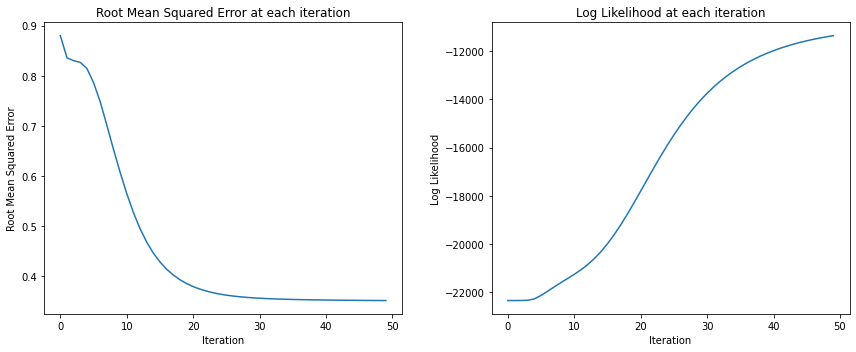

In [535]:
# create a subplot with 2 columns and 1 row
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
# plot the root mean squared error at each iteration
axes[0].plot(range(num_iterations), RMSE)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Root Mean Squared Error')
axes[0].set_title('Root Mean Squared Error at each iteration')
# plot the log likelihood at each iteration
axes[1].plot(range(num_iterations), LOGLOG)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Log Likelihood')
axes[1].set_title('Log Likelihood at each iteration')
plt.tight_layout()
# adjust the subplot layout to favor space between subplots
plt.subplots_adjust(wspace=0.25, hspace=2)
plt.show()

In [536]:
# multiply the last entry of each similarity tuple by 5 to scale the similarity between 1 and 5
movie_similarities = [(movieId1, movieId2, similarity * 5) for movieId1, movieId2, similarity in similarities]

In [537]:
movie_similarities[:10]

[(0, 0, 5.0),
 (0, 1, 3.0),
 (0, 2, 0.8333333333333333),
 (0, 3, 0.0),
 (0, 4, 0.8333333333333333),
 (0, 5, 0.7142857142857142),
 (0, 6, 0.0),
 (0, 7, 1.0),
 (0, 8, 1.25),
 (0, 9, 0.0)]

In [538]:
similarities[:10]

[(0, 0, 1.0),
 (0, 1, 0.6),
 (0, 2, 0.16666666666666666),
 (0, 3, 0.0),
 (0, 4, 0.16666666666666666),
 (0, 5, 0.14285714285714285),
 (0, 6, 0.0),
 (0, 7, 0.2),
 (0, 8, 0.25),
 (0, 9, 0.0)]

In [318]:
movie_similarities = similarities

In [547]:
# calculate the predictions for a single user
user = np.random.choice(len(set([user for user, movie, rating in users_test])))
prediction_test = []
# for user, movie, rating in user:
# calculate the prediction for each user-movie pair
predictions = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
# append the prediction to the prediction_test list
prediction_test.append((user, movie, prediction))

In [548]:
prediction_test

[(399, 974, 3.916264648255295)]

In [551]:
movieId_preds = [movieId for userId, movieId, rating in prediction_test]
movieId_preds

[974]

In [549]:
# check find the top 10 similar  movies for each movieId
# create a list to store the similarity between movie1 and all other movies
similarities = []
movieId_preds = [movieId for userId, movieId, rating in prediction_test]

    for movieId1, genre1 in genres:
        # loop through each movie again
        for movieId2, genre2 in genres:
            # calculate the similarity between movie1 and movie2
            similarity = jaccard_score(genre1, genre2)
            # append the similarity to the similarities list
            similarities.append((movieId1, movieId2, similarity))

KeyboardInterrupt: 

In [319]:
# calculate the predictions for the test set
prediction_test = []
for user, movie, rating in users_test:
    # calculate the prediction for each user-movie pair
    predictions = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    # append the prediction to the prediction_test list
    prediction_test.append((user, movie, prediction))

# for movie in predictions, get the top 5 movies that are most similar to it
# create a dictionary to store the top 5 movies that are most similar to each movie
top_movies = {}
# loop through each movie
for movieId1, movieId2, similarity in movie_similarities:
    # if movieId1 is not in the dictionary, add it
    if movieId1 not in top_movies:
        top_movies[movieId1] = [(movieId2, similarity)]
    # if movieId1 is in the dictionary, append the movieId2 and similarity to the list
    else:
        top_movies[movieId1].append((movieId2, similarity))

# sort the list of similar movies for each movie in descending order of similarity
for movieId1 in top_movies:
    top_movies[movieId1] = sorted(top_movies[movieId1], key=lambda x: x[1], reverse=True)

# get the top 5 movies that are most similar to each movie
for movieId1 in top_movies:
    top_movies[movieId1] = top_movies[movieId1][:5]

In [320]:
prediction_test[:10]

[(0, 638, 3.6456331877729258),
 (0, 527, 3.6456331877729258),
 (0, 665, 3.6456331877729258),
 (0, 200, 3.6456331877729258),
 (0, 752, 3.6456331877729258),
 (0, 512, 3.6456331877729258),
 (2, 347, 3.6456331877729258),
 (3, 195, 3.6456331877729258),
 (3, 286, 3.6456331877729258),
 (3, 298, 3.6456331877729258)]

In [229]:
prediction_test[:10]

[(560, 1088, 3.6456331877729258),
 (560, 832, 3.6456331877729258),
 (582, 295, 3.6456331877729258),
 (381, 1094, 3.6456331877729258),
 (522, 354, 3.6456331877729258),
 (133, 460, 3.6456331877729258),
 (342, 839, 3.6456331877729258),
 (540, 772, 3.6456331877729258),
 (434, 53, 3.6456331877729258),
 (290, 914, 3.6456331877729258)]

In [321]:
top_movies

{0: [(0, 1.0), (187, 1.0), (227, 1.0), (382, 1.0), (70, 0.8333333333333334)],
 1: [(1, 1.0), (15, 1.0), (363, 1.0), (89, 0.75), (25, 0.6666666666666666)],
 2: [(2, 1.0), (4, 1.0), (11, 1.0), (29, 1.0), (41, 1.0)],
 3: [(3, 1.0), (269, 1.0), (342, 1.0), (386, 1.0), (27, 0.75)],
 4: [(2, 1.0), (4, 1.0), (11, 1.0), (29, 1.0), (41, 1.0)],
 5: [(5, 1.0), (18, 1.0), (148, 1.0), (219, 1.0), (222, 1.0)],
 6: [(6, 1.0), (20, 1.0), (84, 1.0), (86, 1.0), (150, 1.0)],
 7: [(7, 1.0), (16, 1.0), (21, 1.0), (22, 1.0), (46, 1.0)],
 8: [(8, 1.0), (270, 0.6), (26, 0.5), (274, 0.5), (281, 0.5)],
 9: [(9, 1.0), (30, 1.0), (33, 1.0), (36, 1.0), (37, 1.0)],
 10: [(10, 1.0),
  (192, 0.6666666666666666),
  (283, 0.6666666666666666),
  (374, 0.6666666666666666),
  (9, 0.5)],
 11: [(2, 1.0), (4, 1.0), (11, 1.0), (29, 1.0), (41, 1.0)],
 12: [(12, 1.0), (67, 1.0), (147, 1.0), (180, 1.0), (185, 1.0)],
 13: [(13, 1.0),
  (352, 1.0),
  (98, 0.6666666666666666),
  (101, 0.6666666666666666),
  (111, 0.6666666666666666

In [539]:
# select a random user from the test set
users_random1 = np.random.choice(len(set([user for user, movie, rating in users_test])))

# get the predictions for the random user
predictions_random1 = [prediction for user, movie, prediction in prediction_test if user == users_random1]

# get the original ratings for the random user
ratings_random1 = [rating for user, movie, rating in users_test if user == users_random1]  

In [540]:
predictions_random1, ratings_random1

([3.6456331877729258,
  3.6456331877729258,
  3.6456331877729258,
  3.6456331877729258],
 [3.0, 4.0, 4.0, 3.5])

In [324]:
# get the movieIds for the random user
movies_random1 = [movie for user, movie, rating in users_test if user == users_random1]

# get the movie titles for the random user
movies_random1 = movies_new[movies_new['movieId'].isin(movies_random1)]['title'].values.tolist()

In [325]:
movies_random1

['Seven (a.k.a. Se7en) (1995)', 'Braveheart (1995)']

In [326]:
# get the movieIds for the predictions
movies_predictions_random1 = [movie for user, movie, prediction in prediction_test if user == users_random1]

# get the movie titles for the predictions
movies_predictions_random1 = movies_new[movies_new['movieId'].isin(movies_predictions_random1)]['title'].values.tolist()


In [327]:
movies_predictions_random1

['Seven (a.k.a. Se7en) (1995)', 'Braveheart (1995)']

In [333]:
# for a specific user, match the movies in the test set with the movies in the top_movies dictionary and calculate the new prediction for each movie in the test set
prediction_genre = []
for user, movie, prediction in prediction_test:
    # if the movie is in the top_movies dictionary, calculate the new prediction
    if movie in top_movies:
        # loop through each movie in the top_movies dictionary
        for movieId2, similarity in top_movies[movie]:
            # if the movie is in the top_movies dictionary, calculate the new prediction
            if movieId2 in top_movies:
                # calculate the new prediction: (old prediction + similarity)*0.5
                prediction_genre.append((user, movieId2, (similarity * (prediction - 2.5))))
                    # sim_scores = sim_scores * (user_rating-2.5)
                    # sim_scores = sim_scores.sort_values(ascending=False

prediction_genre[:10]

[(0, 200, 1.1456331877729258),
 (0, 232, 1.1456331877729258),
 (0, 243, 1.1456331877729258),
 (0, 258, 1.1456331877729258),
 (0, 321, 1.1456331877729258),
 (2, 347, 1.1456331877729258),
 (2, 395, 0.7637554585152838),
 (2, 7, 0.5728165938864629),
 (2, 16, 0.5728165938864629),
 (2, 17, 0.5728165938864629)]

In [307]:
users_test.sort(key=lambda x: x[0])

In [308]:
users_test[:10]

[(0, 638, 5.0),
 (0, 527, 4.0),
 (0, 665, 5.0),
 (0, 200, 3.0),
 (0, 752, 4.0),
 (0, 512, 5.0),
 (2, 347, 3.5),
 (3, 195, 4.0),
 (3, 286, 5.0),
 (3, 298, 2.0)]

In [334]:
# get the ratings for user 0
ratings_user0 = [(movie, rating) for user, movie, rating in users_test if user == 0]

ratings_user0

[(638, 5.0), (527, 4.0), (665, 5.0), (200, 3.0), (752, 4.0), (512, 5.0)]

In [312]:
# get the predictions for user 0
predictions_user0 = [(movie, prediction) for user, movie, prediction in prediction_genre if user == 0]

In [335]:
predictions_user0

[(200, 4.322816593886463),
 (232, 4.322816593886463),
 (243, 4.322816593886463),
 (258, 4.322816593886463),
 (321, 4.322816593886463)]

In [337]:
# get the root mean squared error for the predictions
rmse_genre = np.sqrt(np.mean([(prediction - rating)**2 for user, movie, rating in prediction_genre]))
print(f'Root Mean Squared Error: {rmse_genre}')

Root Mean Squared Error: 2.639568435166103


In [273]:
# select a random user and make predictions for the movies that the user has not rated


In [274]:
# select a random user and make predictions for the movies that the user has not rated
users_random = np.random.choice(len(set([user for user, movie, rating in users_test])))
# get the movies that the user has rated
movies_rated = [movie for user, movie, rating in users_test if user == users_random]
# get the top 10 predictions for the user
top_predictions = sorted(prediction_genre, key=lambda x: x[2], reverse=True)[:10]
# get the movies that the user has not rated
movies_not_rated = [movie for user, movie, prediction in top_predictions if movie not in movies_rated]


In [275]:
users_random

455

In [276]:
movies_rated

[492]

In [277]:
movies_not_rated

[99, 115, 131, 263, 295, 354, 2, 4, 11, 29]

In [278]:
# return the titles of the movies_rated
movies_new[movies_new['movieId'].isin(movies_rated)]['title']

Series([], Name: title, dtype: object)

In [279]:
# return the titles of the movies_not_rated
movies_new[movies_new['movieId'].isin(movies_not_rated)]['title']

2                                Grumpier Old Men (1995)
4                                            Heat (1995)
11                                     Get Shorty (1995)
29                             Mr. Holland's Opus (1995)
99                                       Stargate (1994)
115                                  Forrest Gump (1994)
131                                      Airheads (1994)
263                   Ghost and the Darkness, The (1996)
295    Star Wars: Episode V - The Empire Strikes Back...
354            Indiana Jones and the Last Crusade (1989)
Name: title, dtype: object

In [244]:
# get the length of the unique users in users_test
users_random

521

In [241]:
# get the titles of the index of the top 10 movies from movies_rated
movies_rated = movies_new[movies_new['movieId'].isin(movies_rated)]['title'].values.tolist()

# get the titles of the index of the top 10 movies from movies_not_rated
movies_not_rated = movies_new[movies_new['movieId'].isin(movies_not_rated)]['title'].values.tolist()

print(f'User: {user}')
print(f'Movies rated by user: {movies_rated}')
print("\n")
print(f'Top 10 movie recommendations for user: {movies_not_rated}')


User: 560
Movies rated by user: ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Father of the Bride Part II (1995)', 'Heat (1995)', 'Sabrina (1995)', 'GoldenEye (1995)', 'American President, The (1995)', 'Casino (1995)', 'Sense and Sensibility (1995)', 'Ace Ventura: When Nature Calls (1995)', 'Get Shorty (1995)', 'Copycat (1995)', 'Leaving Las Vegas (1995)', 'City of Lost Children, The (Cité des enfants perdus, La) (1995)', 'Dangerous Minds (1995)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Babe (1995)', 'Dead Man Walking (1995)', 'Clueless (1995)', 'Mortal Kombat (1995)', 'Seven (a.k.a. Se7en) (1995)', 'Pocahontas (1995)', 'Usual Suspects, The (1995)', 'Mighty Aphrodite (1995)', 'Indian in the Cupboard, The (1995)', "Mr. Holland's Opus (1995)", 'Bio-Dome (1996)', 'From Dusk Till Dawn (1996)', 'Broken Arrow (1996)', 'Bottle Rocket (1996)', 'Happy Gilmore (1996)', 'Bridges of Madison County, The (1995)', 'Muppet Treasure Island (1996)', 'Braveheart (1995)', 'Taxi 

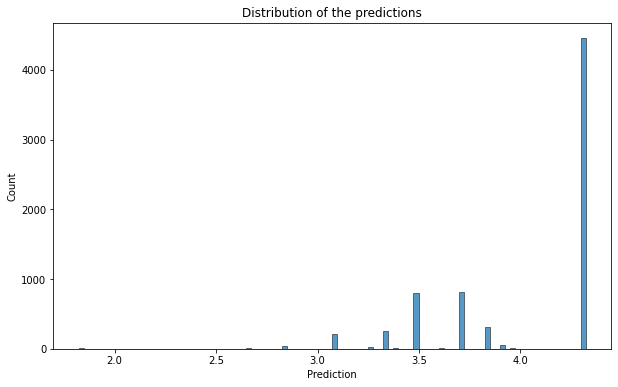

In [237]:
# plot the distribution of the predictions
plt.figure(figsize=(10, 6))
sns.histplot([prediction for user, movie, prediction in prediction_genre], kde=False, bins=100)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Distribution of the predictions')
plt.show()


In [ ]:
# make predictions on the test set
predictions_test = [(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])) for user, movie, rating in users_test]


In [101]:
#update the item factors with the similarity between corresponding movies
for movieId1, movieId2, similarity in similarities:
    item_factors[movieId1] *= similarity

In [92]:
# include the similarity between movies in the model
for movieId1, movieId2, similarity in similarities:
    item_factors[movieId1] += similarity * item_factors[movieId2]

item_factors

array([[-7.52000177e+112,  2.05438166e+112,  7.61087374e+111, ...,
        -7.13772658e+112, -4.28980964e+112, -4.60620982e+112],
       [-1.38244001e+113,  3.77667384e+112,  1.39914546e+112, ...,
        -1.31216442e+113, -7.88617430e+112, -8.46782877e+112],
       [-4.57856397e+112,  1.25081325e+112,  4.63389150e+111, ...,
        -4.34581517e+112, -2.61185681e+112, -2.80449752e+112],
       ...,
       [-7.01259540e-002,  4.19291523e-002, -6.86083739e-002, ...,
         2.20975178e-002, -5.81444228e-002, -6.59428441e-002],
       [ 3.07610815e-002,  2.49294847e-002,  4.56190810e-002, ...,
        -3.57136155e-002,  2.17179242e-002,  4.85097023e-002],
       [-5.88775277e-002, -1.52151274e-002, -1.28090170e-002, ...,
        -6.50248786e-002, -3.24037422e-002, -1.25214841e-002]])

In [ ]:
# calculate the predictions
predictions = np.zeros((n_users, n_items))
for user in range(n_users):
    for movie in range(n_items):
        predictions[user, movie] = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])


In [ ]:
# save the user biases, item biases, user factors and item factors
np.save('../data/biases/user_bias_100k.npy', user_bias)
np.save('../data/biases/item_bias_100k.npy', item_bias)
np.save('../data/biases/user_factors_100k.npy', user_factors)
np.save('../data/biases/item_factors_100k.npy', item_factors)

# save the predictions
np.save('../data/biases/predictions_100k.npy', predictions)

# 4. Hyperparameter Tuning: Grid Search

In [161]:
# Grid search for the best hyperparameters
best_rmse = float('inf')
best_hyperparams = {}


hyperparameter_grid = {
    'num_factors': [50, 100, 1000],
    'lambda_value': [0.01, 0.05, 0.1],
    'tau_value': [0.01, 0.05, 0.1]
}

# print the total number of hyperparameter combinations
print(f'Total number of hyperparameter combinations: {len(list(itertools.product(*hyperparameter_grid.values())))}')

Total number of hyperparameter combinations: 27


In [162]:
# create a csv file to store the results of the grid search
with open('grid_search_results.csv', 'w') as f:
    f.write('num_factors,lambda_value,tau_value,RMSE,log_likelihood,log_stability\n')

In [163]:
# Iterate over all possible combinations of hyperparameters
for hyperparams in itertools.product(*hyperparameter_grid.values()):
    # Unpack the hyperparameters
    num_factors, lambda_value, tau_value = hyperparams
    # print the hyperparemeter combination
    print("Experimenting with hyperparameters:")
    print(f'Hyperparameters: {hyperparams}')

    # Reset biases and factor matrices
    num_iterations = 30
    user_bias = np.zeros(n_users)
    item_bias = np.zeros(n_items)
    user_factors = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))
    item_factors = np.random.normal(scale=1/num_factors, size=(n_items, num_factors))

    # Reset RMSE and log-likelihood lists
    RMSE = []
    LOGLOG = []

    # Run the ALS algorithm
    for _ in range(num_iterations):
        # loop through each user-movie pair and calculate user biases
        for user, movie, rating in users:
            prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
            error = rating - prediction
            user_bias[user] += lambda_value * (error - lambda_value * user_bias[user])
            user_factors[user] += lambda_value * (error * item_factors[movie] - lambda_value * user_factors[user])
        # loop through each user-movie pair and calculate item biases
        for movie, user, rating in movies: 
            prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
            error = rating - prediction
            item_bias[movie] += lambda_value * (error - lambda_value * item_bias[movie])
            item_factors[movie] += lambda_value * (error * user_factors[user] - lambda_value * item_factors[movie])

        # compute the root mean squared error at each iteration, append it to the rmse list and print it for each iteration
        rmse = np.sqrt(np.mean([(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]) - rating)**2 for user, movie, rating in users]))
        RMSE.append(rmse)

        # compute the log likelihood at each iteration, append it to the loglog list and print it for each iteration
        try:
            loglog = -lambda_value/2 * np.sum([(rating - np.dot(user_factors[user], item_factors[movie]))**2 for user, movie, rating in users]) - tau_value/2 * (np.sum([np.dot(user_factors[user], user_factors[user]) for user, movie, rating in users]) + np.sum([np.dot(item_factors[movie], item_factors[movie]) for movie, user, rating in movies]))
            LOGLOG.append(loglog)
        except FloatingPointError:
            print("FloatingPointError: Numerical instability encountered. Adjusting hyperparameters.")
            lambda_value /= 10
            tau_value /= 10
            continue
        log_stability = True
        # check if the log likelihood is stable and increasing
        if len(LOGLOG) > 1:
            if LOGLOG[-1] < LOGLOG[-2]:
                log_stability = False
                print("Numerical instability encountered. Adjusting hyperparameters.")
                lambda_value /= 10
                tau_value /= 10
                break

        # print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')

    # Calculate the lowest RMSE for the current hyperparameters
    lowest_rmse = min(RMSE)
    lowest_loglog = min(LOGLOG)

    # Check if the current hyperparameters result in a better RMSE
    if lowest_rmse < best_rmse and log_stability:
        best_rmse = lowest_rmse
        best_hyperparams = {
            'num_factors': num_factors,
            'lambda_value': lambda_value,
            'tau_value': tau_value
        }
    
    #print the rmses and log likelihoods
    print(f'Best RMSE: {lowest_rmse}')
    print(f'Best Log Likelihood: {lowest_loglog}')
    print('\n')

    # write the all the experiments to grid_search_results.csv
    with open('grid_search_results.csv', 'a') as f:
        f.write(f'{num_factors},{lambda_value},{tau_value},{lowest_rmse},{lowest_loglog},{log_stability}\n')

# write the best hyperparameters to grid_search_results.csv
with open('grid_search_results.csv', 'a') as f:
    # write a new line
    f.write('\n')
    f.write(f'{best_hyperparams["num_factors"]},{best_hyperparams["lambda_value"]},{best_hyperparams["tau_value"]},{best_rmse}\n')

# print the best hyperparameters
print(f'Best hyperparameters: {best_hyperparams}')

# print the best RMSE
print(f'Best RMSE: {best_rmse}')

Experimenting with hyperparameters:
Hyperparameters: (50, 0.01, 0.01)
Numerical instability encountered. Adjusting hyperparameters.
Best RMSE: 1.0280899709345004
Best Log Likelihood: -4480.802024567397


Experimenting with hyperparameters:
Hyperparameters: (50, 0.01, 0.05)
Numerical instability encountered. Adjusting hyperparameters.
Best RMSE: 1.0280501957330161
Best Log Likelihood: -4536.65881705999


Experimenting with hyperparameters:
Hyperparameters: (50, 0.01, 0.1)
Numerical instability encountered. Adjusting hyperparameters.
Best RMSE: 1.0280521687681872
Best Log Likelihood: -4605.9878436251365


Experimenting with hyperparameters:
Hyperparameters: (50, 0.05, 0.01)
Best RMSE: 0.3947988456840902
Best Log Likelihood: -22342.748464047


Experimenting with hyperparameters:
Hyperparameters: (50, 0.05, 0.05)
Numerical instability encountered. Adjusting hyperparameters.
Best RMSE: 0.8321121184822885
Best Log Likelihood: -22408.293595283587


Experimenting with hyperparameters:
Hyperpar

# 5. Model Evaluation: Biases

In [ ]:
# make predictions for user 0
user_0_predictions = user_bias[0] + item_bias + user_factors[0, :].dot(item_factors.T)

# print the predicted ratings for user 0
user_0_predictions

# print the actual ratings for user 0
top_0_movies = ratings_new[ratings_new['userId'] == 0].sort_values('rating', ascending=False)

# return the movie titles of top_0_movies
top_0_movies = movies_new[movies_new['movieId'].isin(top_0_movies['movieId'])]

In [ ]:
user_0_predictions

array([4.39208721, 3.40851527, 3.85392503, ..., 3.99184743, 4.22569774,
       4.84193128])

In [ ]:
top_0_movies

,movieId,title,genres,num_genres,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,Grumpier Old Men (1995),Comedy|Romance,2,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,4,Heat (1995),Action|Crime|Thriller,3,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
23,23,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,2,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
25,25,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,3,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,409,Face/Off (1997),Action|Crime|Drama|Thriller,4,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
410,410,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,3,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
413,413,Conan the Barbarian (1982),Action|Adventure|Fantasy,3,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
420,420,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,4,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# get the top 10 movie recommendations for user 0
top_10_recommendations = np.argsort(user_0_predictions)[::-1][0:10]
# return the movie titles of the top 10 recommendations
movies_new[movies_new['movieId'].isin(top_10_recommendations)]['title']

15     City of Lost Children, The (Cité des enfants p...
197    Wallace & Gromit: The Best of Aardman Animatio...
203               Wallace & Gromit: A Close Shave (1995)
287          Wallace & Gromit: The Wrong Trousers (1993)
295    Star Wars: Episode V - The Empire Strikes Back...
315      Grand Day Out with Wallace and Gromit, A (1989)
337                             Great Escape, The (1963)
Name: title, dtype: object

In [187]:
# get the predictions for user 0
predictions[0]

array([4.39208721, 3.40851527, 3.85392503, ..., 3.99184743, 4.22569774,
       4.84193128])

In [190]:
# get the predictions for user 0 and take the ceiling of the predictions. Cast the predictions to integers
predictions[0].round().astype(int)

array([4, 3, 4, ..., 4, 4, 5])

In [155]:
# get the actual ratings for user 0
ratings_new[ratings_new['userId'] == 0]

,userId,movieId,rating,timestamp,datetime
0,0,0,4.0,964982703,2000-07-30 18:45:03
1,0,2,4.0,964981247,2000-07-30 18:20:47
2,0,4,4.0,964982224,2000-07-30 18:37:04
3,0,23,5.0,964983815,2000-07-30 19:03:35
4,0,25,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...,...
224,0,749,5.0,964981909,2000-07-30 18:31:49
226,0,752,4.0,964982417,2000-07-30 18:40:17
228,0,759,5.0,964981855,2000-07-30 18:30:55
229,0,761,4.0,964981220,2000-07-30 18:20:20


In [156]:
# get the predictins for movie 0
predictions[:, 0]

array([3.97322186, 3.49589311, 1.49546001, 3.20271537, 3.70656348,
       3.93789692, 2.61985796, 3.26458095, 3.88198133, 2.29580418,
       3.6878775 , 4.45459529, 4.04602104, 3.21408283, 2.84825491,
       3.64038469, 3.58479033, 3.11202339, 2.77131849, 4.17975718,
       3.42790397, 1.3338643 , 2.71256994, 3.13154113, 3.93440592,
       3.42225532, 2.8623589 , 3.39209428, 3.67116223, 4.04845437,
       4.15133662, 3.77098556, 3.68644059, 3.76739066, 4.10403578,
       2.60723459, 3.99211026, 3.11330208, 3.43629505, 3.94770411,
       2.18249876, 3.64851534, 4.66623241, 3.31774217, 3.89004416,
       4.44737847, 2.54750931, 3.65761609, 3.98052883, 2.12391332,
       4.18850826, 4.16739267, 3.05407141, 3.05211227, 4.01103422,
       3.49543955, 4.5448065 , 3.13677084, 3.44647344, 3.35505712,
       3.72041842, 3.74238593, 3.57935695, 3.1804758 , 3.74510418,
       3.5892511 , 3.33553117, 3.82347441, 4.13681594, 4.0421387 ,
       4.03708041, 4.34583224, 3.2083861 , 3.25661153, 1.86766

In [157]:
# check the ratings for movie 0
df[df['movieId'] == 0]

,userId,movieId,rating,timestamp,datetime,title,genres,num_genres
0,0,0,4.0,964982703,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,4,0,4.0,847434962,1996-11-08 06:36:02,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
2,6,0,4.5,1106635946,2005-01-25 06:52:26,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
3,14,0,2.5,1510577970,2017-11-13 12:59:30,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
4,16,0,4.5,1305696483,2011-05-18 05:28:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
...,...,...,...,...,...,...,...,...
210,591,0,2.5,1349082950,2012-10-01 09:15:50,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
211,592,0,4.0,964744033,2000-07-28 00:27:13,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
212,593,0,2.5,1117408267,2005-05-29 23:11:07,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
213,594,0,3.0,847221025,1996-11-05 19:10:25,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5


In [177]:
# recommend movies for user 0
# get the predictions for user 0
user_predictions = predictions[0]
# get the indices of the top 10 predictions
top_10_indices = np.argsort(user_predictions)[-10:]
# get the movieIds of the top 10 predictions
top_10_movieIds = [list(new_movieId.keys())[list(new_movieId.values()).index(i)] for i in top_10_indices]
# get the titles of the top 10 predictions
top_10_titles = movies_new[movies_new['movieId'].isin(top_10_indices)]['title'].values.tolist()

# print the top 10 predictions one by one
for i in range(len(top_10_titles)):
    print(f'{i+1}. {top_10_titles[i]}')

1. City of Lost Children, The (Cité des enfants perdus, La) (1995)
2. Wallace & Gromit: The Best of Aardman Animation (1996)
3. Wallace & Gromit: A Close Shave (1995)
4. Wallace & Gromit: The Wrong Trousers (1993)
5. Star Wars: Episode V - The Empire Strikes Back (1980)
6. Grand Day Out with Wallace and Gromit, A (1989)
7. Great Escape, The (1963)


In [178]:
# confirm that these movies have not been rated by user 0, userId=0
df[df['movieId'].isin(top_10_indices) & (df['userId'] == 0)]


,userId,movieId,rating,timestamp,datetime,title,genres,num_genres
6643,0,295,5.0,964981827,2000-07-30 18:30:27,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,3
15599,0,852,5.0,964984002,2000-07-30 19:06:42,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War,3


In [96]:
# get movies similar to movie 0
# get the predictions for movie 0
movie_predictions = predictions[:, 0]
# get the indices of the top 10 predictions
top_10_indices = np.argsort(movie_predictions)[-10:]
# get the movieIds of the top 10 predictions
top_10_movieIds = [list(new_movieId.keys())[list(new_movieId.values()).index(i)] for i in top_10_indices]
# get the titles of the top 10 predictions
top_10_titles = movies_new[movies_new['movieId'].isin(top_10_movieIds)]['title'].values.tolist()
# print the title of movie 0
print(movies_new[movies_new['movieId'] == 0]['title'].values.tolist())
# print the top 10 predictions
print(top_10_titles)

['Toy Story (1995)']
['Before Sunrise (1995)', 'Hudsucker Proxy, The (1994)', 'Philadelphia (1993)']


In [120]:
# get results on the test set
# create a list of tuples of the form (userId, movieId, rating)
users_test = [(int(user[0]), int(user[1]), user[2]) for user in users_test]
movies_test = [(int(movie[0]), int(movie[1]), movie[2]) for movie in movies_test]

# calculate the predictions
predictions_test = np.zeros((n_users, n_items))
for user in range(n_users):
    for movie in range(n_items):
        predictions_test[user, movie] = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])

# calculate the root mean squared error
rmse_test = np.sqrt(np.mean([(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]) - rating)**2 for user, movie, rating in users_test]))
print(f'Root Mean Squared Error on the test set: {rmse_test}')

# calculate the log likelihood
loglog_test = -lambda_value/2 * np.sum([(rating - np.dot(user_factors[user], item_factors[movie]))**2 for user, movie, rating in users_test]) - tau_value/2 * (np.sum([np.dot(user_factors[user], user_factors[user]) for user, movie, rating in users_test]) + np.sum([np.dot(item_factors[movie], item_factors[movie]) for movie, user, rating in movies_test]))
print(f'Log Likelihood on the test set: {loglog_test}')


Root Mean Squared Error on the test set: 3.7594489116606553
Log Likelihood on the test set: -2348.520541905209


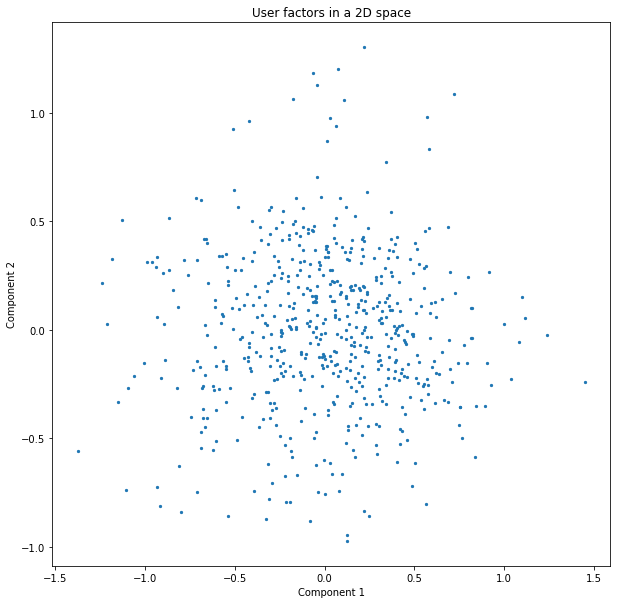

In [180]:
# plot the user factors in a 2D space
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
user_factors_2d = pca.fit_transform(user_factors)
plt.figure(figsize=(10, 10))
plt.scatter(user_factors_2d[:, 0], user_factors_2d[:, 1], s=5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('User factors in a 2D space')
plt.show()


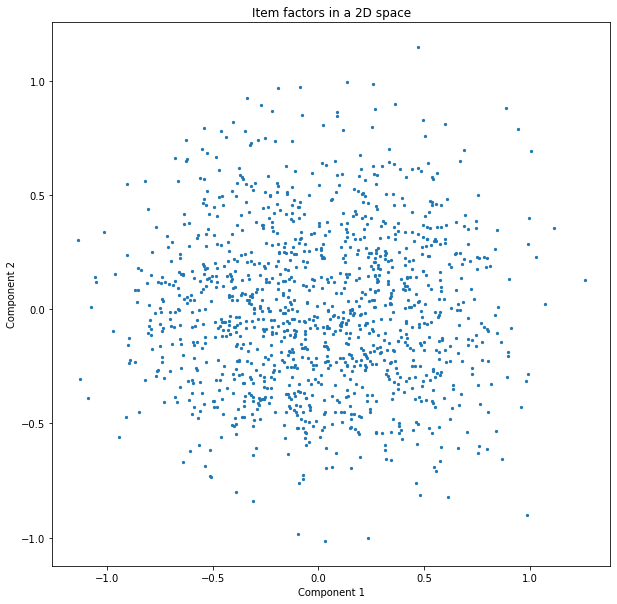

In [181]:
# plot the item factors in a 2D space
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
item_factors_2d = pca.fit_transform(item_factors)
plt.figure(figsize=(10, 10))
plt.scatter(item_factors_2d[:, 0], item_factors_2d[:, 1], s=5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Item factors in a 2D space')
plt.show()

In [ ]:
# prediction for user 0
user_0_predictions = predictions[0]

# prediction for movie 0
movie_0_predictions = user_bias + item_bias[0] + user_factors.dot(item_factors[0, :].T)

In [ ]:
user_0_predictions

array([3.97266767, 2.20873892, 0.6029729 , ..., 4.47228899, 4.42758777,
       4.44526643])

In [ ]:
# update the predictions with the movie similarities
for user in range(n_users):
    for movie in range(n_items):
        # calculate the prediction for each user-movie pair
        prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
        # calculate the weighted average of the predictions
        prediction = prediction * movie_similarities[movie]
        # update the predictions matrix
        predictions[user, movie] = prediction

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

### Parallelization

In [337]:
import multiprocessing

multiprocessing.cpu_count()

8

In [68]:
def calculate_user_biases(user, movie, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    error = rating - prediction
    user_bias[user] += lambda_value * (error - lambda_value * user_bias[user])
    user_factors[user] += lambda_value * (error * item_factors[movie] - lambda_value * user_factors[user])

def calculate_item_biases(movie, user, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    error = rating - prediction
    item_bias[movie] += lambda_value * (error - lambda_value * item_bias[movie])
    item_factors[movie] += lambda_value * (error * user_factors[user] - lambda_value * item_factors[movie])

def calculate_rmse(user, movie, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    return (prediction - rating) ** 2

def calculate_loglikelihood(user, movie, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    return np.log(1 / (1 + np.exp(-prediction)))

In [ ]:
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=4)

    for _ in range(num_iterations):
        # Calculate user biases in parallel
        user_res = pool.starmap(calculate_user_biases, users)
        user_para = user_res.get()

        # Calculate item biases in parallel
        pool.starmap(calculate_item_biases, movies)

        # Calculate RMSE in parallel
        rmse_results = pool.starmap(calculate_rmse, users)
        rmse = np.sqrt(np.mean(rmse_results))
        RMSE.append(rmse)

        # Calculate log likelihood in parallel
        loglik_results = pool.starmap(calculate_loglikelihood, users)
        loglik = np.sum(loglik_results)
        LOGLOG.append(loglik)
        
        print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')


    pool.close()
    pool.join()

In [ ]:
# parrallelize the code using multiprocessing
from multiprocessing import Pool

# Hyperparameters
num_factors = 1000
lambda_value = 0.1
num_iterations = 50
n_items = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()

# Initialize biases
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

# Initialize factor matrices
user_factors = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))
item_factors = np.random.normal(scale=1/num_factors, size=(n_items, num_factors))

# Create lists to store RMSE and log-likelihood for each iteration
RMSE = []
LOGLOG = []

# loop through the number of iterations
for _ in range(num_iterations):
    # loop through each user-movie pair and calculate user biases
    with Pool(4) as p1:
        p1.starmap(calculate_user_biases, users)

    # loop through each user-movie pair and calculate item biases
    with Pool(4) as p2:
        p2.starmap(calculate_item_biases, movies)

    # compute the root mean squared error at each iteration, append it to the rmse list and print it for each iteration
    with Pool(4) as p3:
        rmse_results = p3.starmap(calculate_rmse, users)
    rmse = np.sqrt(np.mean(rmse_results))
    RMSE.append(rmse)

    # compute the log likelihood at each iteration, append it to the loglog list and print it for each iteration
    with Pool(4) as p4:
        loglik_results = p4.starmap(calculate_loglikelihood, users)
    loglik = np.sum(loglik_results)
    LOGLOG.append(loglik)

    print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')



# Digression - Experiment using cosine similarity.

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Filling the sparse matrix with zeros is not a good idea. We can use the mean of the ratings as a proxy for the missing values. This is a simple and effective way to fill in the missing values. It will also help us to avoid the problem of overfitting. We will use the `sklearn` library to calculate the mean of the ratings.

In [54]:
# create a function that standardizes each row (user)
def standardize(row):
    new_row = (row - row.mean())/(row.max() - row.min())
    return new_row

# create a new matrix with standardized values
ratings_std = ratings_matrix.apply(standardize)

# calculate the cosine similarity between users
user_similarity = cosine_similarity(ratings_std)

# calculate the cosine similarity between movies
# we take the transpose of the matrix to get the similarity between movies
item_similarity = cosine_similarity(ratings_std.T)
        

In [ ]:
# create a function that returns the most similar users
def get_similar_users(user_id, user_similarity):
    # get the index of the user that matches the user_id
    idx = ratings_matrix.index.get_loc(user_id)
    
    # create a Series with the similarity scores in descending order
    # drop the user's own similarity score
    sim_scores = pd.Series(user_similarity[idx]).sort_values(ascending=False)
    
    # get the user indices
    user_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar users
    top_users = sim_scores.iloc[1:11].index
    
    # print the user_id and the 10 most similar users
    print('The 10 most similar users for User {} are:)'.format(user_id))
    for i in top_users:
        print(ratings_matrix.index[i])

In [55]:
get_similar_users(1, user_similarity)

The 10 most similar users for User 1 are:)
313
266
57
469
368
452
19
597
217
135


In [56]:
# create a function that returns the most similar movies
def get_similar_movies(movie_id, item_similarity):
    # get the index of the movie that matches the movie_id
    idx = ratings_matrix.columns.get_loc(movie_id)
    
    # create a Series with the similarity scores in descending order
    # drop the movie's own similarity score
    sim_scores = pd.Series(item_similarity[idx]).sort_values(ascending=False)
    
    # get the movie indices
    movie_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar movies
    top_movies = sim_scores.iloc[1:11].index
    
    # print the movie_id and the 10 most similar movies
    print('The 10 most similar movies for Movie {} are:)'.format(movie_id))
    for i in top_movies:
        print(ratings_matrix.columns[i])

In [57]:
get_similar_movies(1, item_similarity)

The 10 most similar movies for Movie 1 are:)
3114
1265
780
1073
648
788
2355
364
34
4886


In [93]:
# print the movie_id and the 10 most similar movies and their similarity scores with movie titles
def get_similar_movies(movie_id, item_similarity, user_rating):
    # get the index of the movie that matches the movie_id
    idx = ratings_matrix.columns.get_loc(movie_id)
    
    # create a Series with the similarity scores in descending order
    # drop the movie's own similarity score
    sim_scores = pd.Series(item_similarity[idx])
    # scale the similarity scores so that user rating can be considered
    sim_scores = sim_scores * (user_rating-2.5)
    sim_scores = sim_scores.sort_values(ascending=False)
    
    # get the movie indices
    movie_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar movies
    top_movies = sim_scores.iloc[1:11].index
    
    # print the movie_id and the 10 most similar movies
    print('The 10 most similar movies for Movie {} {} are:)'.format(movie_id, movies[movies['movieId'] == ratings_matrix.columns[idx]]['title'].values[0]))
    for i in top_movies:
        print(ratings_matrix.columns[i], sim_scores[i], movies[movies['movieId'] == ratings_matrix.columns[i]]['title'].values[0])
        
get_similar_movies(356, item_similarity,4)

The 10 most similar movies for Movie 356 Forrest Gump (1994) are:)
480 0.6804485215599689 Jurassic Park (1993)
500 0.6606902061812354 Mrs. Doubtfire (1993)
318 0.6167698303340495 Shawshank Redemption, The (1994)
150 0.5855610032337975 Apollo 13 (1995)
597 0.5852691787933728 Pretty Woman (1990)
110 0.5614109303785232 Braveheart (1995)
296 0.5606638672059776 Pulp Fiction (1994)
364 0.537211883052519 Lion King, The (1994)
377 0.5221630911178504 Speed (1994)
586 0.5134442777352655 Home Alone (1990)


In [110]:
# create a function that takes in a user list of movies and ratings, and returns the top 10 recommended movies for that user
def get_recommendations(user_id, user_similarity, item_similarity):
    # get the index of the user that matches the user_id
    idx = ratings_matrix.index.get_loc(user_id)
    
    # get the user ratings
    user_ratings = ratings_matrix.iloc[idx].values
    
    # create a Series with the movie titles
    movie_titles = ratings_matrix.columns
    
    # create a list to store the similarity scores
    sim_scores = []
    
    # for each movie
    for i in range(len(user_ratings)):
        # if the user has rated the movie
        if user_ratings[i] > 0:
            # for each item in the item_similarity array
            for j in range(len(item_similarity[i])):
                # calculate the similarity score
                sim_scores.append((item_similarity[i][j], movie_titles[j]))
    
    # sort the scores
    sim_scores = sorted(sim_scores, key=lambda x: x[0], reverse=True)
    
    # get the scores of the 10 most similar movies
    sim_scores = sim_scores[:10]
    
    # get the movie indices
    movie_indices = [i[1] for i in sim_scores]


    # print out the top 10 movies that the user has watched with movie titles and ratings
    print('The top 10 movies that User {} has watched are:'.format(user_id))
    for i in ratings_matrix.iloc[idx].sort_values(ascending=False)[:10].index:
        print(i, ratings_matrix.iloc[idx][i], movies[movies['movieId'] == i]['title'].values[0])

        


    # print the top 10 most similar movies
    print('\n')
    print('The top 10 recommended movies for User {}  are:'.format(user_id))
    for i in movie_indices:
        print(i, movies[movies['movieId'] == ratings_matrix.columns[i]]['title'].values[0])

get_recommendations(524, user_similarity, item_similarity)

The top 10 movies that User 524 has watched are:
150 5.0 Apollo 13 (1995)
1200 5.0 Aliens (1986)
1266 5.0 Unforgiven (1992)
1275 5.0 Highlander (1986)
1278 5.0 Young Frankenstein (1974)
494 5.0 Executive Decision (1996)
457 5.0 Fugitive, The (1993)
1242 5.0 Glory (1989)
1291 5.0 Indiana Jones and the Last Crusade (1989)
1303 5.0 Man Who Would Be King, The (1975)


The top 10 recommended movies for User 524  are:
193 Drop Zone (1994)
1208 Air Force One (1997)
485 Tombstone (1993)
1356 Borrowers, The (1997)
10 American President, The (1995)
6 Sabrina (1995)
445 Poetic Justice (1993)
880 Double Life of Veronique, The (Double Vie de Véronique, La) (1991)
151 Mad Love (1995)
457 Romper Stomper (1992)


8

for m=0...M...1:
    numerator = 0
    denominator = alpha

    for (n,r) in get_user_ratings(m):
        numerator += lambda(rating-item_bias[n])**2
        denominator += lambda

    userbias[m] = numerator/denominator

    Parallisation Libraries

for parfor (code)

code(a,b): loop over users a to b